# BackTrader 入门和基本概念介绍

在这个 Notebook 中我们会简单介绍 Backtrader 中的整体框架和重要编程概念，并且用一个趋势跟随策略（15日均线）来进行演示。Backtrader是目前功能最完善的Python量化回测框架之一，是一个易懂、易上手的量化投资框架。

开始之前，先确保环境中有 Python 和 pip 。建议选择 Python 3 (Data Science) 内核。

### 准备工作

首先，输入以下命令安装Backtrader模块:

In [1]:
!pip install backtrader -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


看到 Successfully installed xxx 则说明安装成功。这时可以尝试运行以下代码进行验证：

In [2]:
import backtrader as bt

SageMaker Studio 中的默认路径是/root。在开始之前，我们先将当前路径加入环境变量：

In [3]:
import sys

directory = '/root/sagemaker-backtrader-examples'
if directory not in sys.path:
    sys.path.append(directory)
    
output_bucket = 'athena-output-cache' # 之前创建的 Athena 输出桶名

### BackTrader 入门

接下来我们将尝试编写并运行一个Backtrader回测程序。BackTrader的回测程序主要包括以下几个组成部分：

  - 数据加载（Data Feed）：将交易策略的数据加载到回测框架中。
  - 交易策略（Strategy）：最核心的交易算法部分，需要设计交易决策，生成买卖信号。 
  - 回测框架设置和运行（Cerebro）：需要设置初始资金、佣金比例、数据馈送、交易策略、交易头寸大小等。随后运行Cerebro回测并打印出所有已执行的交易。
  - 评估结果（Analyzers）:以图形和风险收益等指标对交易策略的回测结果进行评价。

对于每个组件部分的详细介绍，将在下个Notebook中进行介绍。

#### 一、数据加载

在 Backtrader 平台中，回测数据由 Lines 类进行表示。回测数据通常包含数个完整的时间序列，通常包括以下数据列：Open（开盘价）, High（最高价）, Low（最低价）, Close（收盘价）, Volume（成交量）, OpenInterest。Data Feeds（数据加载）、Indicators（技术指标）和Strategies（策略）都会生成 Lines，每个 Lines 类可以包含多个 line series 时间序列。在下面的示例中，我们将通过 DataFrame 作为数据源创建一个 Data Feed，并且创建一个名为 SMA（均线）的技术指标。

首先，通过以下代码创建一个向Athena提交查询请求的函数，请注意以下需要定义 Athena 的输出目录：

In [4]:
%%writefile {directory}/data_util.py
import boto3
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as lines
import matplotlib.patches as patches
import pandas as pd
import time


# 从 Athena 中调取数据的函数
def get_query_result(QueryString, output_bucket):
 
    athena = boto3.client('athena')
    s3 = boto3.client('s3')

    def execute_query(QueryString):

        ResultConfiguration = dict([])
        ResultConfiguration['OutputLocation'] = 's3://{}/'.format(output_bucket)
        response = athena.start_query_execution(QueryString=QueryString, ResultConfiguration=ResultConfiguration)
        QueryExecutionId = response['QueryExecutionId']

        flag = True
        while flag:
            response = athena.get_query_execution(QueryExecutionId=QueryExecutionId)
            if response['QueryExecution']['Status']['State'] == 'SUCCEEDED':
                flag = False
                OutputLocation = response['QueryExecution']['ResultConfiguration']['OutputLocation']
                return OutputLocation
            elif response['QueryExecution']['Status']['State'] == 'FAILED':
                flag = False
                print(response['QueryExecution']['Status'])
                return
            else:
                time.sleep(0.5)

    output_location = execute_query(QueryString)
#     print(output_location)
    response = s3.get_object(Bucket=output_bucket, Key=output_location.split('/')[-1])
    df = pd.read_csv(response['Body'])
    
    return df


# 画 K 线图的函数
def plot_candle_stick(prices):

    n = len(prices)
    
    fig = plt.figure(figsize=(20, 12))

    ax = fig.add_axes([0.1, 0.15, 0.8, 0.7])
    ax.set_facecolor('black')
    ax.set_axisbelow(True)

    ax.grid(False, axis='x')
    ax.grid(True, axis='y')
    ax.set_xlim(-1, n)
    ax.set_ylim(min(prices['low']) * 0.97, max(prices['high']) * 1.03)
    ax.set_xticks(range(0, n, max(int(n / 10), 1)))
    ax.set_xticklabels([prices.index.tolist()[index] for index in ax.get_xticks()])

    for i in range(0, n):
        openPrice = prices['open'].iloc[i]
        closePrice = prices['close'].iloc[i]
        highPrice = prices['high'].iloc[i]
        lowPrice = prices['low'].iloc[i]
        if closePrice > openPrice:
            ax.add_patch(
                patches.Rectangle((i - 0.2, openPrice), 0.4, closePrice - openPrice, fill=False, color='r'))
            ax.plot([i, i], [lowPrice, openPrice], 'r')
            ax.plot([i, i], [closePrice, highPrice], 'r')
        else:
            ax.add_patch(patches.Rectangle((i - 0.2, openPrice), 0.4, closePrice - openPrice, color='c'))
            ax.plot([i, i], [lowPrice, highPrice], color='c')
            
    return fig

Overwriting /root/sagemaker-backtrader-examples/data_util.py


通过调用这个函数，我们可以用 SQL 语句查询之前存放在 S3 和 Glue 的数据。以下的SQL语句将调取贵州茅台（600519）自2018年年初到数据截止日的开盘价、收盘价、最高价、最低价、成交量、当日是否开盘和复权因子。随后我们将存放在 S3 的 CSV 查询结果加载为一个 Pandas DataFrame：

In [5]:
from data_util import get_query_result

database = 'stock-data-demo'
table = 'stock_day'
fields = 'ticker,tradedate,openprice,closeprice,highestprice,lowestprice,turnovervol,isopen,accumadjfactor'
ticker = '600519'
orderby = 'tradedate'
sort = 'ASC'

query_string = f'''
SELECT DISTINCT {fields}
FROM "{database}"."{table}"
WHERE ticker='{ticker}'
AND tradedate>='2019-01-01'
ORDER BY {orderby}
{sort}
'''

df = get_query_result(query_string, output_bucket)
df.head()

,ticker,tradedate,openprice,closeprice,highestprice,lowestprice,turnovervol,isopen,accumadjfactor
0,600519,2019-01-02,609.98,598.98,612.00,595.01,6228649.0,True,7.211773
1,600519,2019-01-03,599.97,590.00,601.66,585.80,3097735.0,True,7.211773
2,600519,2019-01-04,587.28,602.00,607.67,582.02,3768347.0,True,7.211773
3,600519,2019-01-07,608.00,605.49,612.00,602.22,3475013.0,True,7.211773
4,600519,2019-01-08,605.50,604.79,612.00,600.28,2883813.0,True,7.211773


因为原始数据包含的是未复权过的价格，对于大多数回测任务而言，需要修正派息等事件对股票价格的影响。因此接下来首先需要对开盘价、收盘价、最高价、最低价进行复权，同时根据isopen条件筛选出开盘的交易日：

In [6]:
df['ticker'] = df['ticker'].apply(lambda x: str(x))
df['ticker'] = df['ticker'].apply(lambda x: '0'*(6-len(x)) + x)
df['openprice'] = df['openprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['closeprice'] = df['closeprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['highestprice'] = df['highestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['lowestprice'] = df['lowestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df = df[df['isopen'] == True]
df.drop('isopen', 1, inplace=True)
df.drop('accumadjfactor', 1, inplace=True)
df.set_index('tradedate', inplace=True)

# Backtrader 对每种数据的来源都有一定的标准，最好先将 pandas 中的数据列命名为标准格式
df.rename(columns={'openprice': 'open'}, inplace=True)
df.rename(columns={'closeprice': 'close'}, inplace=True)
df.rename(columns={'highestprice': 'high'}, inplace=True)
df.rename(columns={'lowestprice': 'low'}, inplace=True)
df.rename(columns={'turnovervol': 'volume'}, inplace=True)
df['openinterest'] = 0 # A股中一般并不考虑 interest 这一概念，先设为零

对DataFrame不太熟悉的朋友可能会觉得不太直观。如果有必要我们可以先简单勾画一下这支股票的K线图：

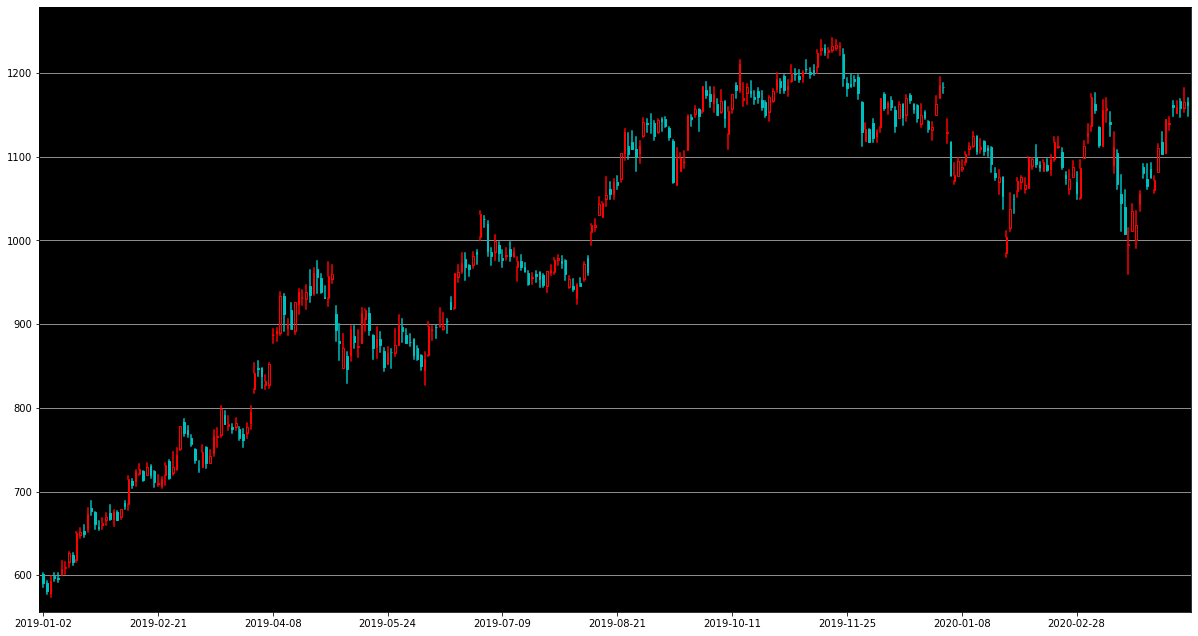

In [7]:
from data_util import plot_candle_stick
            
fig = plot_candle_stick(df)

#### 二、交易策略

交易策略即交易执行所需的核心逻辑。在Backtrader中，交易策略由backtrader.Strategy类进行定义。交易策略中一般至少需要定义以下代码：


1、全局参数。全局参数是在策略中通过tuples或dict定义的值。在这个策略中我们只设定了一个maperiod（均线周期）值为15。

2、初始化。Python中类的constructor由__init__()来定义。Backtrader中的交易策略是一个backtrader.Strategy类。

3、策略核心逻辑。以下策略模块的核心在next()函数中进行定义。该模块包含了执行买卖交易指令的条件。通常来讲策略必须在每个周期开始时进行持仓检查、可用资金检查、指令成交状态检查等，因此必须包含一些if/else条件作为基础。以下的示例中只包含了一个15日均线的判断条件：如果股价突破15日均线则买入，跌破15日均线则卖出。

4、记录日志（可选）。通常来讲策略执行中需要记录持仓、可用资金、逐笔交易的手续费和收益等日志指标，以方便回测结束后进行分析。


In [8]:
from datetime import datetime
import backtrader as bt

class MyStrategy(bt.Strategy):
    ## 1、全局参数
    params=(('maperiod', 15),
            ('printlog', False),)

    ## 2、初始化
    def __init__(self):

        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.size = 80

        # 添加15日移动均线指标。Backtrader 集成了 talib，可以自动算出一些常见的技术指标
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)

    ## 3、策略核心逻辑
    def next(self):
        # 记录收盘价
#         self.log('收盘价：%.2f' % self.datas[0].close[0])
        if self.order: # 检查是否有指令等待执行
            return
        # 检查是否持仓   
        if not self.position: # 没有持仓
            # 执行买入条件判断：收盘价格上涨突破15日均线
            if self.datas[0].close > self.sma[0]:
                self.log('买入：%.2f' % self.datas[0].close[0])
                #执行买入
                self.order = self.buy(size=self.size)
        else:
            # 执行卖出条件判断：收盘价格跌破15日均线
            if self.datas[0].close < self.sma[0]:
                self.log('卖出：%.2f' % self.datas[0].close[0])
                #执行卖出
                self.order = self.sell(size=self.size)

    ## 4、日志记录
    # 交易记录日志（可选，默认不输出结果）
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    # 记录交易执行情况（可选，默认不输出结果）
    def notify_order(self, order):
        # 如果 order 为 submitted/accepted，返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果 order 为 buy/sell executed，报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入：\n价格：%.2f,\
                交易金额：-%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.value, order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：%.2f,\
                交易金额：%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.price*self.size, order.executed.comm))
            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    # 回测结束后输出结果（可省略，默认输出结果）
    def stop(self):
        self.log('(MA均线： %2d日) 期末总资金 %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)

#### 三、回测框架设置和运行

下面我们将定义一个主函数，用于对某股票（贵州茅台）在指定期间进行回测。

该程序将使用我们之前在Athena准备好的接口获取数据。获取完的数据将以pandas DataFrame的形式提供给Backtrader，在此我们可以使用之前准备好的DataFrame：

In [9]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime
import numpy as np
import pandas as pd
import os.path
import sys

import backtrader as bt

if __name__ == '__main__':
    # 创建 Cerebro 对象
    cerebro = bt.Cerebro()

    # 创建 Data Feed
    df.index = pd.to_datetime(df.index)
    start = df.index[0]
    end = df.index[-1]
    print(start, '-', end)
    data = bt.feeds.PandasData(dataname=df, fromdate=start, todate=end)
    # 将 Data Feed 添加至 Cerebro
    cerebro.adddata(data)

    # 添加策略 Cerebro
    cerebro.addstrategy(MyStrategy, maperiod=15, printlog=True)
    
    # 设置初始资金
    cerebro.broker.setcash(100000.0)
    # 设置手续费为万二
    cerebro.broker.setcommission(commission=0.0002) 

    # 在开始时 print 初始账户价值
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # 运行回测流程
    cerebro.run()

    # 在结束时 print 最终账户价值
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

2019-01-02 00:00:00 - 2020-04-13 00:00:00
Starting Portfolio Value: 100000.00
2019-01-22,买入：661.21
2019-01-23,买入：
价格：657.48,                交易金额：-52598.65,                手续费：10.52
2019-03-08,卖出：726.74
2019-03-11,卖出:
价格：729.24,                交易金额：58339.23,                手续费：11.67
2019-03-11,策略收益：
毛收益 5740.59, 净收益 5718.40
2019-03-11,买入：747.47
2019-03-12,买入：
价格：752.67,                交易金额：-60213.87,                手续费：12.04
2019-03-12,卖出：734.14
2019-03-13,卖出:
价格：734.62,                交易金额：58769.66,                手续费：11.75
2019-03-13,策略收益：
毛收益 -1444.21, 净收益 -1468.01
2019-03-13,买入：743.00
2019-03-14,买入：
价格：745.95,                交易金额：-59676.23,                手续费：11.94
2019-05-06,卖出：892.78
2019-05-07,卖出:
价格：880.24,                交易金额：70419.53,                手续费：14.08
2019-05-07,策略收益：
毛收益 10743.30, 净收益 10717.28
2019-05-15,买入：913.47
2019-05-16,买入：
价格：905.59,                交易金额：-72447.10,                手续费：14.49
2019-05-17,卖出：893.56
2019-05-20,卖出:
价格：886.87,                交易金额：70949.2

#### 四、结果的可视化

我们可以看到策略在执行后获得了20%左右的收益。Backtrader 还提供了画图功能：

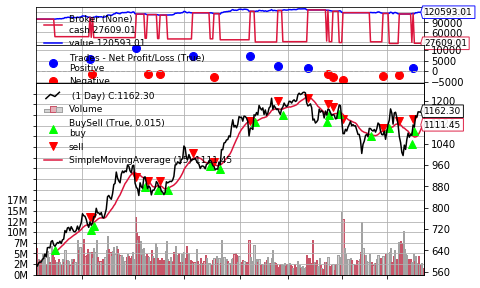

[[<Figure size 432x288 with 4 Axes>]]

In [10]:
cerebro.plot(iplot=False)

上图中最上面的蓝色和红色实线分别代表账户价值和现金。往下的红色和蓝色点位分别表示买入和卖出产生的现金流。再往下的黑色实线代表价格曲线，红色实线代表15日均线，绿色和红色箭头分别代表买入和卖出点位。最下面的柱状图代表当日的成交量。


在完成此Notebook之后您应该对Backtrader有了一些基本了解。接下来的Notebook将对一些平台基本概念作出详细解释，并且结合AWS SageMaker的机器学习能力进行更加深入的策略研究。